# fontanenetzwerke

In diesem Notebook findet sich der zugehörige Python-Code für meinen
veröffentlichten Blogpost, in dem ich Figurennetzwerke für Theodor Fontanes Roman 'Der Stechlin' bespreche:
s. https://www.fontanearchiv.de/blogbeitrag/2021/06/2/der-stechlin-vernetzt?cHash=c427eb77b055cf88deb60b37fab3d115

In [1]:
import pandas as pd
import networkx as nx
from pyvis.network import Network
#import pyvis
import operator
import matplotlib.pyplot as plt

# Wer spricht mit wem?

In [3]:
def get_edges_from_df(df, columnname1, columnname2):
      edges = []
      for number in range(len(df)-1):
        edges.append((df[str(columnname1)].iloc[number], df[str(columnname2)].iloc[number]))
      return edges

def get_weighted_edges_from_edges(edges):
      weighted_edges = []
      already_counted = []
      for entry in edges:
          if entry not in already_counted:
              weighted_edges.append((entry[0], entry[1], edges.count(entry)))
              already_counted.append(entry)
      return weighted_edges

In [4]:
# Einlesen der Daten zur Property 'Sprecher:innen'
df_sprecher = pd.read_csv("data/sprechakt_sprecher.csv", sep=";")
df_sprecher[:5]

,text,id,Sprecher
0,Vielleicht. Aber schlechte Musikanten. Alle Me...,361070,Dubslav
1,"Na, die passen wenigstens. Diokletian war ja w...",732803,Dubslav
2,"Nein«, sagte Woldemar. »Ich kann es mir aber ü...",441329,Woldemar
3,"Ach Gott, gnäd'ger Herr, nu is es doch so geko...",663583,Engelke
4,"»Das ist der Wulkowsche, Herr Hauptmann!«",199268,Fritz


In [5]:
#Verhältnis der direkten Sprechakte zum Gesamttext berechnen (nach Wörtern)
sprechakte = ""
for i in range(0, len(df_sprecher)):
    sprechakte = sprechakte + str(df_sprecher["text"].iloc[i])
    
cleaned_sprechakte = [token.strip('.,:;«»[]-?!/()1234567890') for token in sprechakte.split()]
datei = open('data/stechlin.txt','r') # Die hier und auch für die Annotation verwendete txt-Datei ist zu finden auf TextGrid Repository
full_stechlin = datei.read()
cleaned_full_stechlin = [token.strip('.,:;«»[]-?!/()1234567890') for token in sprechakte.split()]

print("Der Anteil von Sprechakten an Fontanes Der Stechlin beträgt ca. " + str(len(sprechakte)/len(full_stechlin)))

Der Anteil von Sprechakten an Fontanes Der Stechlin beträgt ca. 0.6050384795810987


In [6]:
# Einlesen der Daten zur Property 'Gegenüber"
df_gegenueber = pd.read_csv("data/sprechakt_gegenueber.csv", sep=";")
df_gegenueber[:5]

,text,id,Gegenueber
0,Vielleicht. Aber schlechte Musikanten. Alle Me...,361070,Lorenzen
1,"Na, die passen wenigstens. Diokletian war ja w...",732803,Krippenstapel
2,"Nein«, sagte Woldemar. »Ich kann es mir aber ü...",441329,Melusine
3,"Ach Gott, gnäd'ger Herr, nu is es doch so geko...",663583,Dubslav
4,"»Das ist der Wulkowsche, Herr Hauptmann!«",199268,Czako


In [7]:
# Zusammenführung der beiden Datensätze
df_sprechakt = pd.merge(df_sprecher, df_gegenueber, on='id')
df_sprechakt[:5]

,text_x,id,Sprecher,text_y,Gegenueber
0,Vielleicht. Aber schlechte Musikanten. Alle Me...,361070,Dubslav,Vielleicht. Aber schlechte Musikanten. Alle Me...,Lorenzen
1,"Na, die passen wenigstens. Diokletian war ja w...",732803,Dubslav,"Na, die passen wenigstens. Diokletian war ja w...",Krippenstapel
2,"Nein«, sagte Woldemar. »Ich kann es mir aber ü...",441329,Woldemar,"Nein«, sagte Woldemar. »Ich kann es mir aber ü...",Melusine
3,"Ach Gott, gnäd'ger Herr, nu is es doch so geko...",663583,Engelke,"Ach Gott, gnäd'ger Herr, nu is es doch so geko...",Dubslav
4,"»Das ist der Wulkowsche, Herr Hauptmann!«",199268,Fritz,"»Das ist der Wulkowsche, Herr Hauptmann!«",Czako


In [8]:
#Auslesen der Kanten # Das separate Erfassen von Knoten und Katen ermöglicht später die Färbung in vers. Farben
edges_sprechakt= get_edges_from_df(df_sprechakt, "Sprecher", "Gegenueber")
#edges_sprechakt[:5]

In [9]:
#Auslesen der Knoten
names = {entry for entry in df_sprechakt.Sprecher}.union({entry for entry in df_sprechakt.Gegenueber})
#print("Menge der Knoten: " + str(len(names)))

In [14]:
# Gerichtetes Netzwerk
G_sprechakt = nx.DiGraph()

for name in names:
    G_sprechakt.add_node(name, size=5)

for entry in edges_sprechakt:
    G_sprechakt.add_edge(entry[0], entry[1], color="grey")


ngd_sprechakt = Network("600px", "800px", directed=True)
ngd_sprechakt.from_nx(G_sprechakt)
ngd_sprechakt.show_buttons(filter_=['physics'])
ngd_sprechakt.show("networks/ngd_sprechakt.html")



In [15]:
# Stufenweise Gewichtung des Netzwerks
edges_sprechakt_wei = get_weighted_edges_from_edges(edges_sprechakt)
edges_sprechakt_wei[:5]

# Netzwerk mit Kantendicke nach Gewichtung
G_sprechakt_gewichtet = nx.DiGraph()

for name in names:
    G_sprechakt_gewichtet.add_node(name, size=5)

for entry in edges_sprechakt_wei:
    if entry[2] == 1:
        G_sprechakt_gewichtet.add_edge(entry[0], entry[1], weight=entry[2], width=0.5, color="grey")
    elif entry[2] < 5:
        G_sprechakt_gewichtet.add_edge(entry[0], entry[1], weight=entry[2], width=1, color="grey")
    elif entry[2] < 10:
        G_sprechakt_gewichtet.add_edge(entry[0], entry[1], weight=entry[2], width=2, color="grey")
    else:
        G_sprechakt_gewichtet.add_edge(entry[0], entry[1], weight=entry[2], width=5, color="grey")
    
  
ngd_sprechakt_gewichtet = Network("600px", "800px", directed=True)
ngd_sprechakt_gewichtet.from_nx(G_sprechakt_gewichtet)
ngd_sprechakt_gewichtet.show_buttons(filter_=['physics'])
ngd_sprechakt_gewichtet.show("networks/ngdg_sprechakt.html")

## Einfärben der Knoten des Netzwerks nach verschiedenen Parametern

In [16]:
# Einlesen der Figurenuebersicht, in der Wohnort, Geschlecht etc. über die Figuren erfasst wurde
df_figurenuebersicht = pd.read_csv("data/figurenuebersicht.csv", sep=";")
df_figurenuebersicht[:5]

,Figur,Geschlecht,Wohnort,Schicht
0,Dubslav,m,Stechlin,Adel
1,Woldemar,m,Berlin,Adel
2,Engelke,m,Stechlin,Dienstboten
3,Martin,m,Stechlin,Dienstboten
4,Mamsell Pritzbur,w,Stechlin,Dienstboten


In [18]:
# Netzwerk gefärbt nach Wohnort
G_sprechakt_whnrt = nx.DiGraph()

for i in range(0, len(df_figurenuebersicht)):
    if df_figurenuebersicht["Wohnort"].iloc[i] == "Berlin":
        G_sprechakt_whnrt.add_node(df_figurenuebersicht["Figur"].iloc[i], size=5, color="blue")
    elif df_figurenuebersicht["Wohnort"].iloc[i] == "Stechlin":
        G_sprechakt_whnrt.add_node(df_figurenuebersicht["Figur"].iloc[i], size=5, color="red")
    elif df_figurenuebersicht["Wohnort"].iloc[i] == "Wutz":
        G_sprechakt_whnrt.add_node(df_figurenuebersicht["Figur"].iloc[i], size=5, color="yellow")
    elif df_figurenuebersicht["Wohnort"].iloc[i] == "Mark":
        G_sprechakt_whnrt.add_node(df_figurenuebersicht["Figur"].iloc[i], size=5, color="orange")
    else: 
        G_sprechakt_whnrt.add_node(df_figurenuebersicht["Figur"].iloc[i], size=5, color="grey")

for entry in edges_sprechakt:
    G_sprechakt_whnrt.add_edge(entry[0], entry[1], width=0.4, color="grey")
    
ngd_sprechakt = Network("600px", "800px")
ngd_sprechakt.from_nx(G_sprechakt_whnrt)
ngd_sprechakt.show_buttons(filter_=['physics'])
ngd_sprechakt.write_html("networks/ngd_sprechakt_col_wohnort.html")

In [19]:
# Netzwerk gefärbt nach Adel/Nicht-Adel
G_sprechakt_adl = nx.DiGraph()
for i in range(0, len(df_figurenuebersicht)):
    if df_figurenuebersicht["Schicht"].iloc[i] == "Adel":
        G_sprechakt_adl.add_node(df_figurenuebersicht["Figur"].iloc[i], size=5, color="orange")
    else:
        G_sprechakt_adl.add_node(df_figurenuebersicht["Figur"].iloc[i], size=5, color="blue")
for entry in edges_sprechakt:
    G_sprechakt_adl.add_edge(entry[0], entry[1], width=0.4, color="grey")
    
ngd_sprechakt = Network("600px", "800px")
ngd_sprechakt.from_nx(G_sprechakt_adl)
ngd_sprechakt.show_buttons(filter_=['physics'])
ngd_sprechakt.show("networks/ngd_sprechakt_col_adel.html")

In [20]:
# Netzwerk gefärbt nach Gender
G_sprechakt_gender = nx.DiGraph()

for i in range(0, len(df_figurenuebersicht)):
    if df_figurenuebersicht["Geschlecht"].iloc[i] == "w":
        G_sprechakt_gender.add_node(df_figurenuebersicht["Figur"].iloc[i], size=5, color="red")
    else:
        G_sprechakt_gender.add_node(df_figurenuebersicht["Figur"].iloc[i], size=5, color="yellow")

for entry in edges_sprechakt:
    G_sprechakt_gender.add_edge(entry[0], entry[1], width=0.4, color="grey")

  
ngd_sprechakt = Network("800px", "1200px")

ngd_sprechakt.from_nx(G_sprechakt_gender)
ngd_sprechakt.show_buttons(filter_=['physics'])
ngd_sprechakt.show("networks/ngd_sprechakt_col_gender.html")

## Berechnung der Zentralitätsmaße

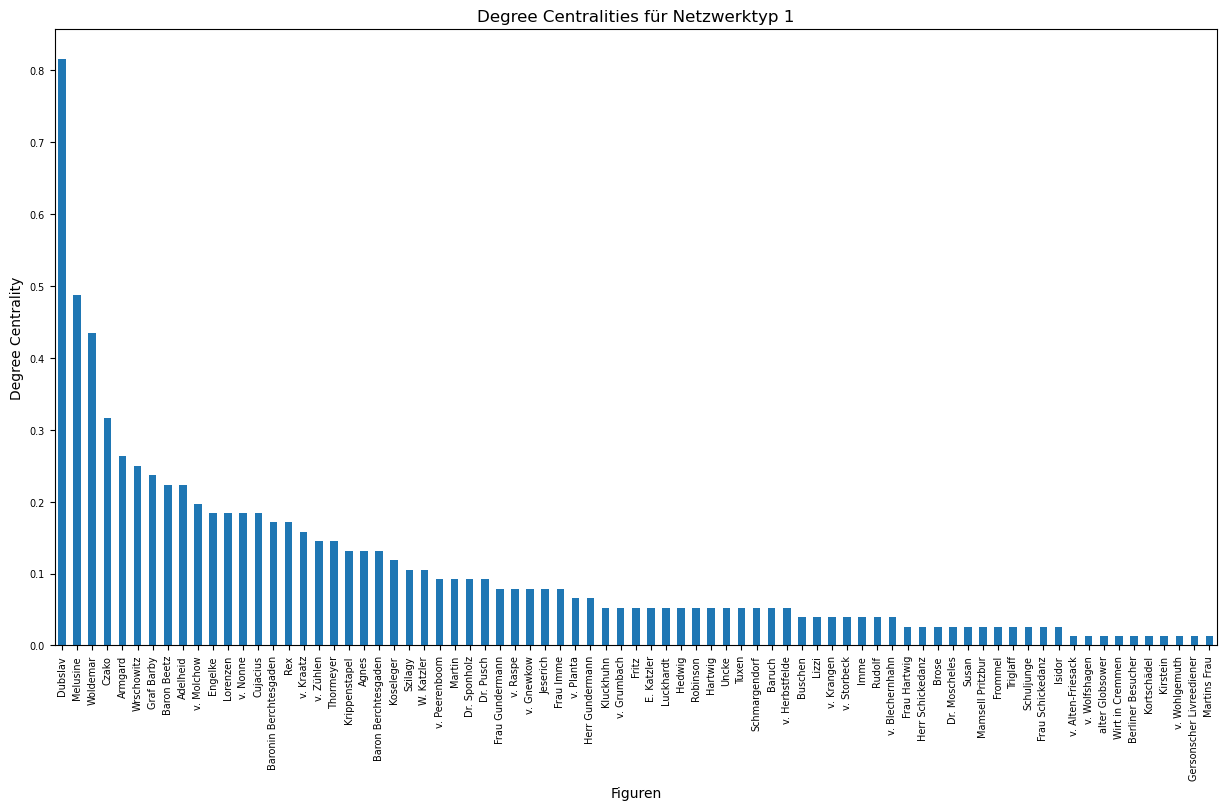

In [25]:
degree_centrality = nx.degree_centrality(G_sprechakt)
degree_centrality = dict(sorted(degree_centrality.items(), key=operator.itemgetter(1),reverse=True))

values = [wert for wert in degree_centrality.values()]
values = pd.Series(values)

x_labels = degree_centrality.keys()

# Plot the figure.
plt.figure(figsize=(15, 8))
ax = values.plot(kind='bar', fontsize="7")
ax.set_title("Degree Centralities für Netzwerktyp 1")
ax.set_xlabel('Figuren')
ax.set_ylabel('Degree Centrality')
ax.set_xticklabels(x_labels)
rects = ax.patches
plt.savefig("figures/dc_sprechakt.png")

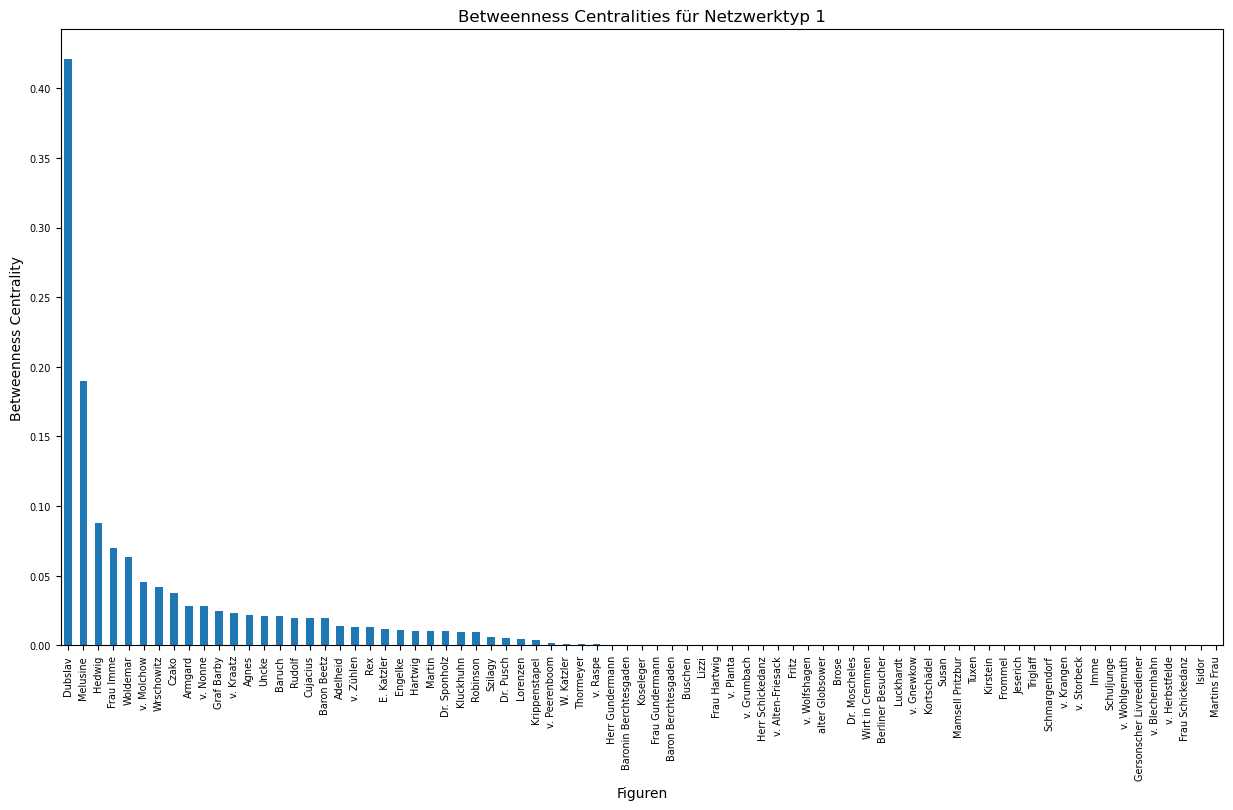

In [27]:
betweenness_centrality = nx.betweenness_centrality(G_sprechakt)
betweenness_centrality = dict(sorted(betweenness_centrality.items(), key=operator.itemgetter(1),reverse=True))

values = [wert for wert in betweenness_centrality.values()]
values = pd.Series(values)

x_labels = betweenness_centrality.keys()

# Plot the figure.
plt.figure(figsize=(15, 8))
ax = values.plot(kind='bar', fontsize="7")
ax.set_title("Betweenness Centralities für Netzwerktyp 1")
ax.set_xlabel('Figuren')
ax.set_ylabel('Betweenness Centrality')
ax.set_xticklabels(x_labels)
rects = ax.patches
plt.savefig("figures/bc_sprechakt.png")

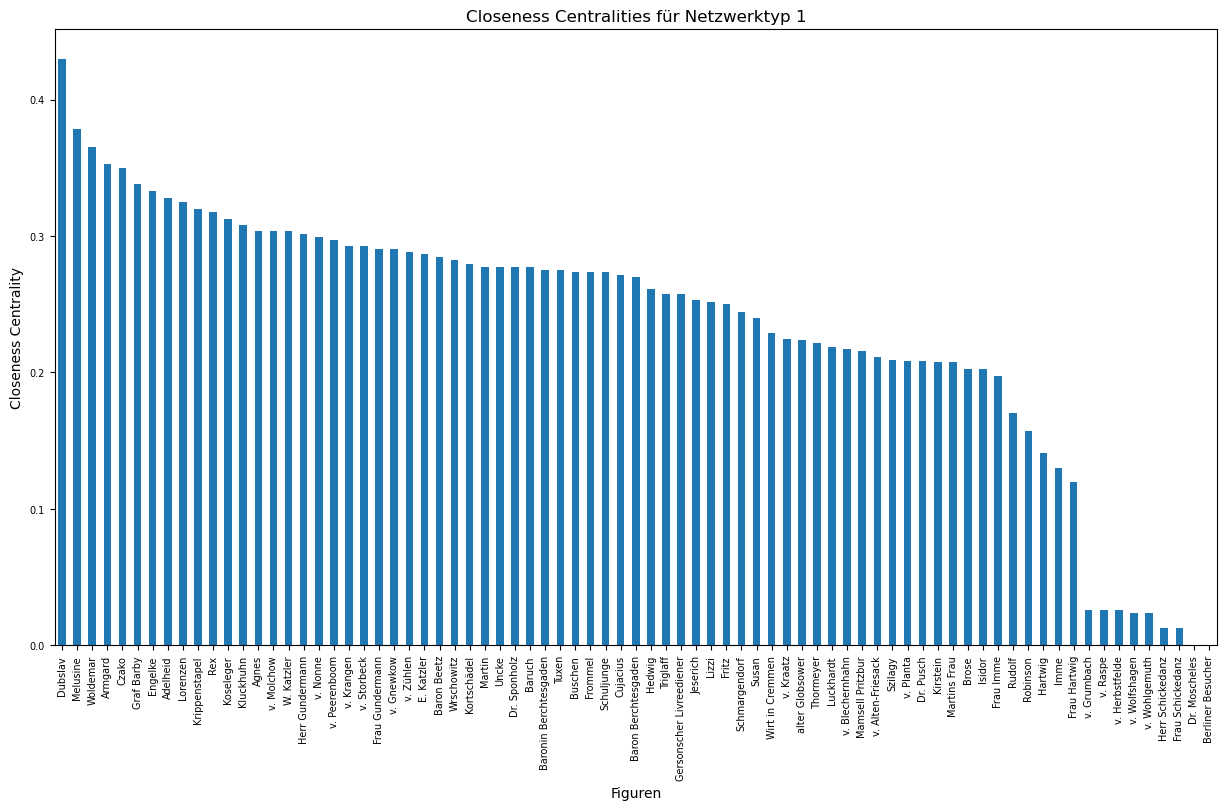

In [28]:
closeness_centrality = nx.closeness_centrality(G_sprechakt)
closeness_centrality = dict(sorted(closeness_centrality.items(), key=operator.itemgetter(1),reverse=True))

values = [wert for wert in closeness_centrality.values()]
values = pd.Series(values)

x_labels = closeness_centrality.keys()

# Plot the figure.
plt.figure(figsize=(15, 8))
ax = values.plot(kind='bar', fontsize="7")
ax.set_title("Closeness Centralities für Netzwerktyp 1")
ax.set_xlabel('Figuren')
ax.set_ylabel('Closeness Centrality')
ax.set_xticklabels(x_labels)
rects = ax.patches
plt.savefig("figures/cc_sprechakt.png")

# Referenzen auf Figuren: Wer spricht über wen?

In [31]:
df_rnd= pd.read_csv("data/referenz_referierende_Figuren.csv", sep=";")
df_rnd[:5]

,query,text,id,referierende_Figur
0,"tag=""/Referenz"" property=""referierende_Figur""@...",Herr von Stechlin hat eben von einem der Humbo...,99710,Rex
1,"tag=""/Referenz"" property=""referierende_Figur""@...","Koseleger voll Vertrauen! Na, dann geht es gew...",361478,Dubslav
2,"tag=""/Referenz"" property=""referierende_Figur""@...",Und so wird es Woldemar auch machen?,750453,Dubslav
3,"tag=""/Referenz"" property=""referierende_Figur""@...",Und all das kaufte sich meine Mutter. Und an d...,209859,Czako
4,"tag=""/Referenz"" property=""referierende_Figur""@...","Wir könnten es mit Katzler versuchen, aber da ...",505177,Dubslav


In [32]:
df_rt= pd.read_csv("data/referenz_referierte_Figuren.csv", sep=";")
df_rt[:5]

,query,text,id,referierte_Figur
0,"tag=""/Referenz"" property=""referierte_Figur""@20...",Herr von Stechlin hat eben von einem der Humbo...,99710,Alexander von Humboldt
1,"tag=""/Referenz"" property=""referierte_Figur""@20...",Herr von Stechlin hat eben von einem der Humbo...,99710,Wilhelm von Humboldt
2,"tag=""/Referenz"" property=""referierte_Figur""@20...","Koseleger voll Vertrauen! Na, dann geht es gew...",361478,Koseleger
3,"tag=""/Referenz"" property=""referierte_Figur""@20...",Und so wird es Woldemar auch machen?,750453,Woldemar
4,"tag=""/Referenz"" property=""referierte_Figur""@20...",Und all das kaufte sich meine Mutter. Und an d...,209859,Czakos Mutter


In [33]:
df_rt_rnd = pd.merge(df_rnd, df_rt, on='id')
df_rt_rnd[:5]

,query_x,text_x,id,referierende_Figur,query_y,text_y,referierte_Figur
0,"tag=""/Referenz"" property=""referierende_Figur""@...",Herr von Stechlin hat eben von einem der Humbo...,99710,Rex,"tag=""/Referenz"" property=""referierte_Figur""@20...",Herr von Stechlin hat eben von einem der Humbo...,Alexander von Humboldt
1,"tag=""/Referenz"" property=""referierende_Figur""@...",Herr von Stechlin hat eben von einem der Humbo...,99710,Rex,"tag=""/Referenz"" property=""referierte_Figur""@20...",Herr von Stechlin hat eben von einem der Humbo...,Wilhelm von Humboldt
2,"tag=""/Referenz"" property=""referierende_Figur""@...","Koseleger voll Vertrauen! Na, dann geht es gew...",361478,Dubslav,"tag=""/Referenz"" property=""referierte_Figur""@20...","Koseleger voll Vertrauen! Na, dann geht es gew...",Koseleger
3,"tag=""/Referenz"" property=""referierende_Figur""@...",Und so wird es Woldemar auch machen?,750453,Dubslav,"tag=""/Referenz"" property=""referierte_Figur""@20...",Und so wird es Woldemar auch machen?,Woldemar
4,"tag=""/Referenz"" property=""referierende_Figur""@...",Und all das kaufte sich meine Mutter. Und an d...,209859,Czako,"tag=""/Referenz"" property=""referierte_Figur""@20...",Und all das kaufte sich meine Mutter. Und an d...,Czakos Mutter


In [34]:
#Auslesen der Kanten
edges_rfz= get_edges_from_df(df_rt_rnd, "referierende_Figur", "referierte_Figur")
#edges_rfz[:5]

In [35]:
#Auslesen der Knoten
names = {entry for entry in df_rt_rnd.referierende_Figur}.union({entry for entry in df_rt_rnd.referierte_Figur})

In [36]:
# Netzwerk der Referenzen
G_rfz = nx.DiGraph()

for name in names:
    G_rfz.add_node(name, size=5, color="purple")

for entry in edges_rfz:
    G_rfz.add_edge(entry[0], entry[1], color="grey")

  
ngd_rfz = Network("800px", "1200px", directed=True)
ngd_rfz.from_nx(G_rfz)
ngd_rfz.show_buttons(filter_=['physics'])
ngd_rfz.show("networks/ngd_rfz.html")


In [37]:
# Netzwerk der Referenzen nur mit handelnden Figuren

handelnde_figuren = [figur for figur in df_figurenuebersicht["Figur"]]
edges_rfz_cleared = [edge for edge in edges_rfz if edge[0] in handelnde_figuren and edge[1] in handelnde_figuren]


G_rfz_cleared = nx.DiGraph()

for name in handelnde_figuren:
    G_rfz_cleared.add_node(name, size=5, color="purple")#die separate Erfassung der Knoten ermöglicht später die Färbung in vers. Farben

for entry in edges_rfz_cleared:
    G_rfz_cleared.add_edge(entry[0], entry[1], color="grey")

  
ngd_rfz_cleared = Network("600px", "800px", directed=True)
ngd_rfz_cleared.from_nx(G_rfz_cleared)
ngd_rfz_cleared.show("networks/ngd_rfz_cleared.html")


# Berechnung der Zentralitätsmaße für das Referenzen-Netzwerk

In [38]:
degree_centrality = nx.degree_centrality(G_rfz_cleared)
degree_centrality = dict(sorted(degree_centrality.items(), key=operator.itemgetter(1),reverse=True))

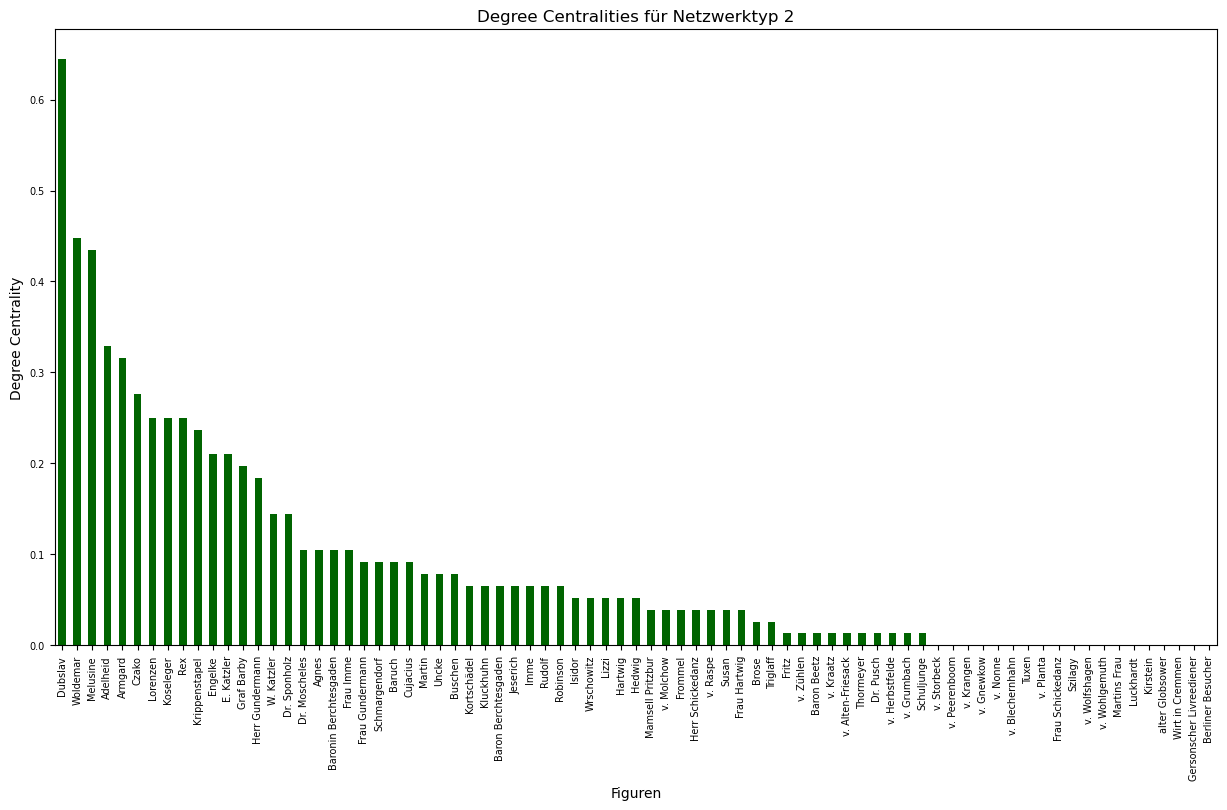

In [40]:
values = [wert for wert in degree_centrality.values()]
values = pd.Series(values)
x_labels = degree_centrality.keys()

# Plot the figure.
plt.figure(figsize=(15, 8))
ax = values.plot(kind='bar', color="darkgreen", fontsize="7")
ax.set_xlabel('Figuren')
ax.set_ylabel('Degree Centrality')
ax.set_title("Degree Centralities für Netzwerktyp 2")
ax.set_xticklabels(x_labels)
rects = ax.patches
plt.savefig("figures/dc_rfz.png")


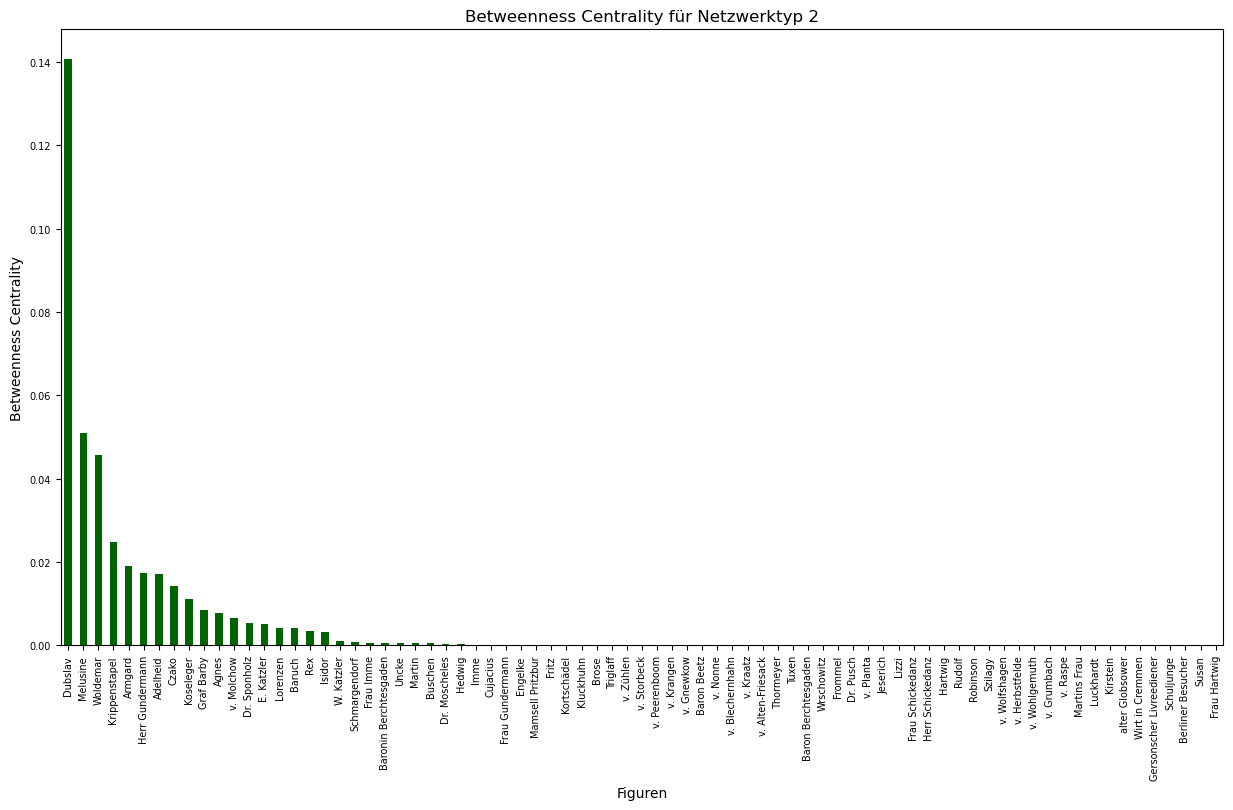

In [41]:
betweenness_centrality = nx.betweenness_centrality(G_rfz_cleared)
betweenness_centrality = dict(sorted(betweenness_centrality.items(), key=operator.itemgetter(1),reverse=True))

values = [wert for wert in betweenness_centrality.values()]
values = pd.Series(values)

x_labels = betweenness_centrality.keys()

# Plot the figure.
plt.figure(figsize=(15, 8))
ax = values.plot(kind='bar', color="darkgreen", fontsize="7")
ax.set_title("Betweenness Centrality für Netzwerktyp 2")
ax.set_xlabel('Figuren')
ax.set_ylabel('Betweenness Centrality')
ax.set_xticklabels(x_labels)
rects = ax.patches
plt.savefig("figures/bc_rfz.png")

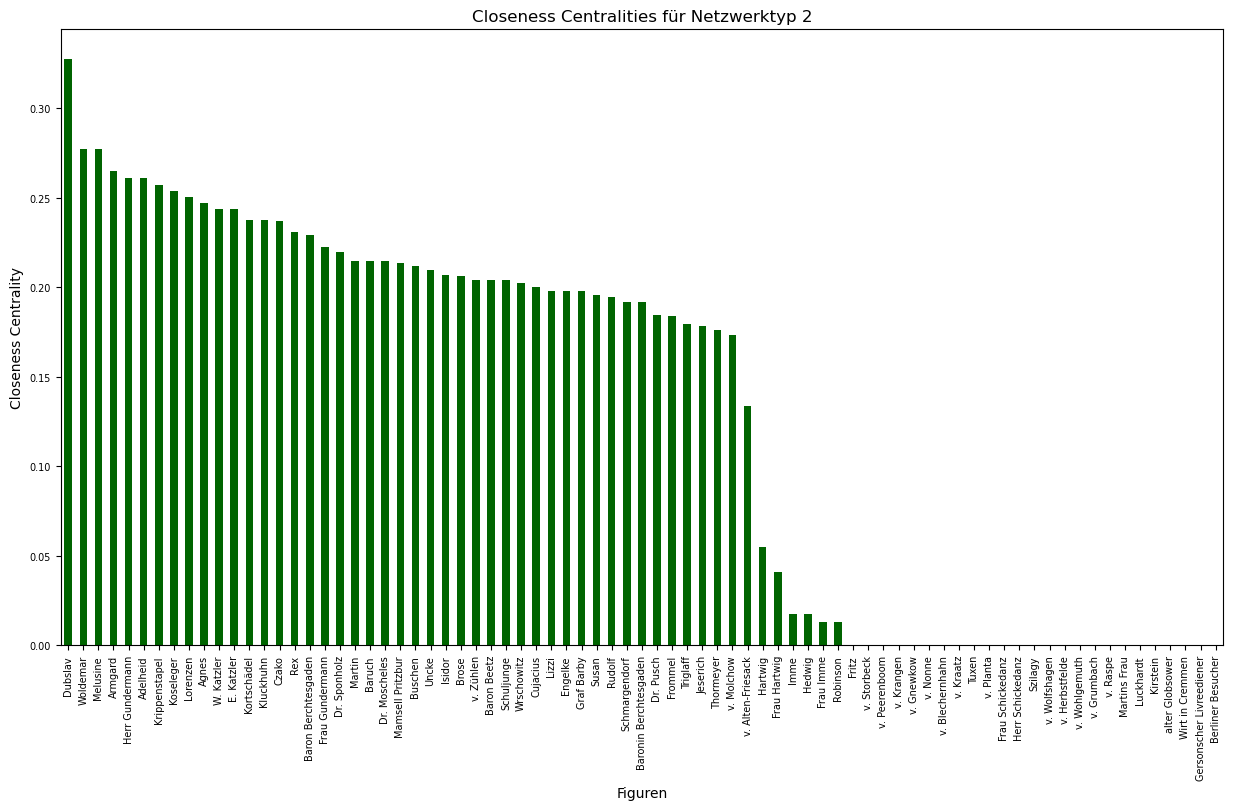

In [42]:
closeness_centrality = nx.closeness_centrality(G_rfz_cleared)
closeness_centrality = dict(sorted(closeness_centrality.items(), key=operator.itemgetter(1),reverse=True))

values = [wert for wert in closeness_centrality.values()]
values = pd.Series(values)

x_labels = closeness_centrality.keys()

# Plot the figure.
plt.figure(figsize=(15, 8))
ax = values.plot(kind='bar', color="darkgreen", fontsize="7")
ax.set_title("Closeness Centralities für Netzwerktyp 2")
ax.set_xlabel('Figuren')
ax.set_ylabel('Closeness Centrality')
ax.set_xticklabels(x_labels)
rects = ax.patches
plt.savefig("figures/cc_rfz.png")